In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO

In [87]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fathomnet-out-of-sample-detection/sample_submission.csv
/kaggle/input/fathomnet-out-of-sample-detection/demo_download.ipynb
/kaggle/input/fathomnet-out-of-sample-detection/category_key.csv
/kaggle/input/fathomnet-out-of-sample-detection/download_images.py
/kaggle/input/fathomnet-out-of-sample-detection/requirements.txt
/kaggle/input/fathomnet-out-of-sample-detection/multilabel_classification/train.csv
/kaggle/input/fathomnet-out-of-sample-detection/object_detection/train.json
/kaggle/input/fathomnet-out-of-sample-detection/object_detection/eval.json


# category_key.csv

In [88]:
category_key = pd.read_csv('/kaggle/input/fathomnet-out-of-sample-detection/category_key.csv')
category_key.head()

,id,name,supercat
0,1,Actiniaria,Anemone
1,2,Actinernus,Anemone
2,3,Actiniidae,Anemone
3,4,Actinoscyphia,Anemone
4,5,Bolocera,Anemone


In [89]:
print(f'There are {len(set(category_key.name))} different fine grained categories (classes to predict).')

There are 290 different fine grained categories (classes to predict).


In [90]:
print(f'There are {len(set(category_key.supercat))} emantic supercategories (auxiliary labels).')

There are 20 emantic supercategories (auxiliary labels).


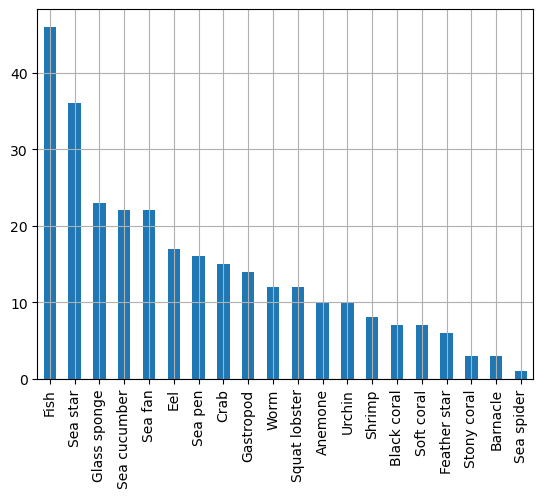

Fish             46
Sea star         36
Glass sponge     23
Sea cucumber     22
Sea fan          22
Eel              17
Sea pen          16
Crab             15
Gastropod        14
Worm             12
Squat lobster    12
Anemone          10
Urchin           10
Shrimp            8
Black coral       7
Soft coral        7
Feather star      6
Stony coral       3
Barnacle          3
Sea spider        1
Name: supercat, dtype: int64


In [91]:
num_classes_per_supercat = category_key.supercat.value_counts()
plt.figure()
num_classes_per_supercat.plot(kind='bar')
plt.grid()
plt.show()

print(num_classes_per_supercat)

# Train data

## multilabel_classification/train.csv

In [92]:
train_csv = pd.read_csv('/kaggle/input/fathomnet-out-of-sample-detection/multilabel_classification/train.csv')
train_csv.head()

,id,categories
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"


In [93]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5950 non-null   object
 1   categories  5950 non-null   object
dtypes: object(2)
memory usage: 93.1+ KB


In [94]:
train_csv.categories = train_csv.categories.apply(lambda x: json.loads(x))
train_csv.categories = train_csv.categories.apply(lambda x: list(map(int, x)))
train_csv['label_count'] = train_csv.categories.apply(lambda x: len(x))
train_csv.head()

,id,categories,label_count
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1],1
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1],1
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1],1
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1, 9, 11, 88]",4
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1, 37, 51, 119]",4


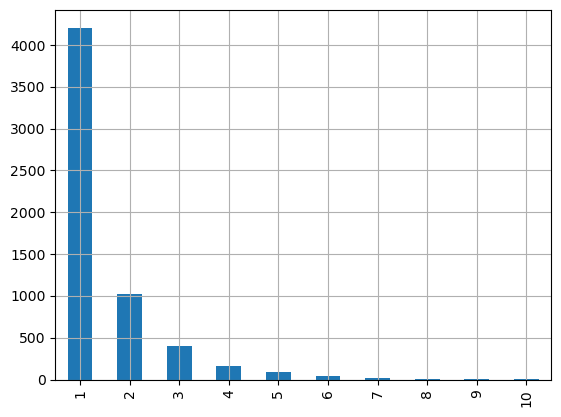

1     4209
2     1022
3      404
4      160
5       86
6       40
7       15
8        7
9        5
10       2
Name: label_count, dtype: int64


In [95]:
num_labeled_objects_per_img = train_csv['label_count'].value_counts()

plt.figure()
num_labeled_objects_per_img.plot(kind='bar')
plt.grid()
plt.show()

print(num_labeled_objects_per_img)

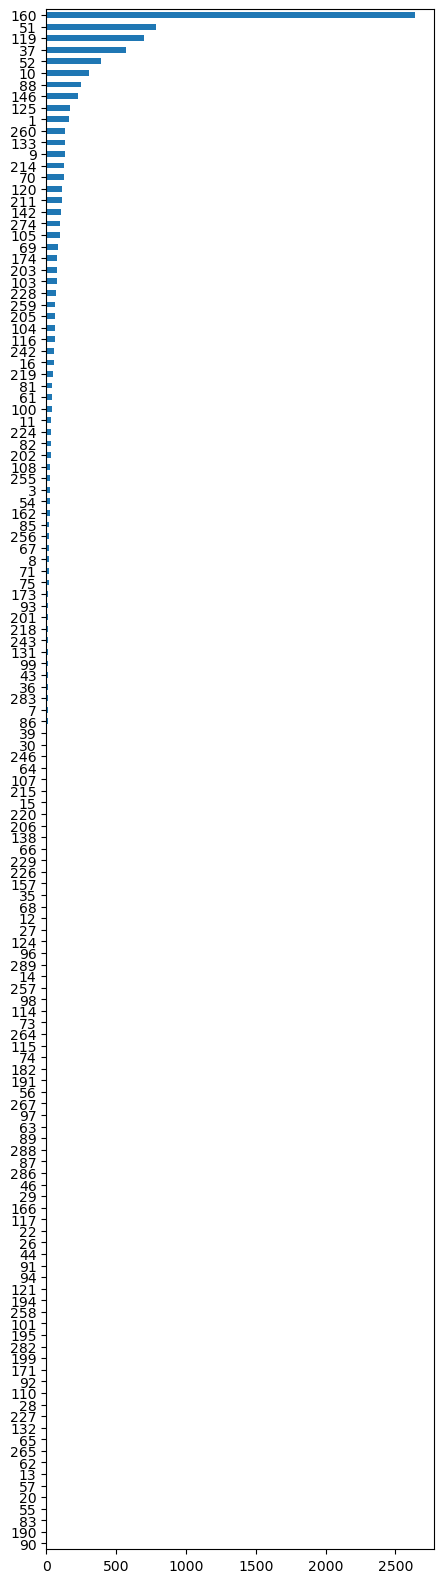

160    2643
51      785
119     697
37      568
52      394
       ... 
20        1
55        1
83        1
190       1
90        1
Length: 133, dtype: int64


In [96]:
num_samples_per_class = pd.value_counts(np.concatenate(train_csv.categories))

plt.figure(figsize=(5, 20))
num_samples_per_class[::-1].plot(kind='barh')
plt.show()

print(num_samples_per_class)

## object_detection/train.json

In [97]:
with open('../input/fathomnet-out-of-sample-detection/object_detection/train.json') as f:
    train_json = json.load(f)
print(train_json.keys())

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


### info

In [98]:
train_json['info']

{'year': 2023,
 'version': '0',
 'description': 'Generated by FathomNet',
 'contributor': 'FathomNet',
 'url': 'https://fathomnet.org',
 'date_created': '2023/01/26'}

## images

In [99]:
train_json_images = pd.json_normalize(train_json['images'])
train_json_images.drop(['license'], axis=1, inplace=True)
train_json_images.head()

,id,width,height,file_name,flickr_url,coco_url,date_captured
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34
1,2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38
2,3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44
3,4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14
4,5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00


In [100]:
train_json_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             5950 non-null   int64 
 1   width          5950 non-null   int64 
 2   height         5950 non-null   int64 
 3   file_name      5950 non-null   object
 4   flickr_url     5950 non-null   object
 5   coco_url       5950 non-null   object
 6   date_captured  5950 non-null   object
dtypes: int64(3), object(4)
memory usage: 325.5+ KB


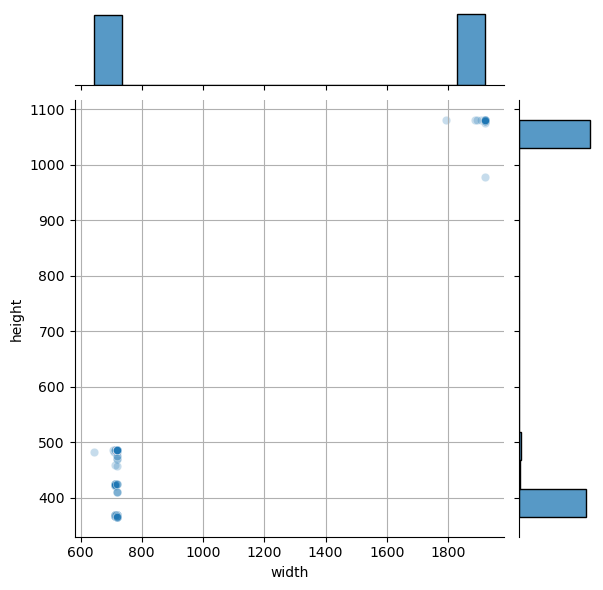

In [101]:
sns.jointplot(train_json_images, x='width', y='height', alpha=0.25)
plt.grid()
plt.show()

## licenses

In [102]:
train_json['licenses']

[{'id': 0,
  'name': 'FathomNet',
  'url': 'http://fathomnet.org/fathomnet/#/license'}]

## annotations

In [103]:
train_json_annots = pd.json_normalize(train_json['annotations'])
train_json_annots.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,1,1,1.0,[],7869.0,"[347.0, 188.0, 129.0, 61.0]",0
1,2,2,1.0,[],8775.0,"[346.0, 191.0, 135.0, 65.0]",0
2,3,3,1.0,[],8768.0,"[343.0, 192.0, 137.0, 64.0]",0
3,4,4,88.0,[],315.0,"[623.0, 95.0, 21.0, 15.0]",0
4,5,4,1.0,[],440.0,"[361.0, 175.0, 22.0, 20.0]",0


An image can have more than one annotation, so df_train_annots has more rows than df_train_images...

In [104]:
train_json_annots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23704 entries, 0 to 23703
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            23704 non-null  int64  
 1   image_id      23704 non-null  int64  
 2   category_id   23704 non-null  float64
 3   segmentation  23704 non-null  object 
 4   area          23704 non-null  float64
 5   bbox          23704 non-null  object 
 6   iscrowd       23704 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.3+ MB


In [105]:
assert all(isinstance(cat_id, float) and cat_id == int(cat_id) for cat_id in train_json_annots.category_id)
train_json_annots.category_id = train_json_annots.category_id.apply(lambda x: int(x))
train_json_annots.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,1,1,1,[],7869.0,"[347.0, 188.0, 129.0, 61.0]",0
1,2,2,1,[],8775.0,"[346.0, 191.0, 135.0, 65.0]",0
2,3,3,1,[],8768.0,"[343.0, 192.0, 137.0, 64.0]",0
3,4,4,88,[],315.0,"[623.0, 95.0, 21.0, 15.0]",0
4,5,4,1,[],440.0,"[361.0, 175.0, 22.0, 20.0]",0


In [106]:
assert all(cat_id in category_key.name for cat_id in train_json_annots.category_id)
print(f'There are samples with {len(set(train_json_annots.category_id))} categories in training set '
      f'out of {len(set(category_key.name))} possible classes')

There are samples with 133 categories in training set out of 290 possible classes


Columns "segmentation" and "iscrowd" contain no info, both are constant. So we can safely remove them.

In [107]:
print(set(train_json_annots.iscrowd))
train_json_annots.drop(['iscrowd'], axis=1, inplace=True)
train_json_annots.head()

{0}


,id,image_id,category_id,segmentation,area,bbox
0,1,1,1,[],7869.0,"[347.0, 188.0, 129.0, 61.0]"
1,2,2,1,[],8775.0,"[346.0, 191.0, 135.0, 65.0]"
2,3,3,1,[],8768.0,"[343.0, 192.0, 137.0, 64.0]"
3,4,4,88,[],315.0,"[623.0, 95.0, 21.0, 15.0]"
4,5,4,1,[],440.0,"[361.0, 175.0, 22.0, 20.0]"


In [108]:
print(set(list(map(len, train_json_annots.segmentation))))
train_json_annots.drop(['segmentation'], axis=1, inplace=True)
train_json_annots.head()

{0}


,id,image_id,category_id,area,bbox
0,1,1,1,7869.0,"[347.0, 188.0, 129.0, 61.0]"
1,2,2,1,8775.0,"[346.0, 191.0, 135.0, 65.0]"
2,3,3,1,8768.0,"[343.0, 192.0, 137.0, 64.0]"
3,4,4,88,315.0,"[623.0, 95.0, 21.0, 15.0]"
4,5,4,1,440.0,"[361.0, 175.0, 22.0, 20.0]"


In [109]:
def drop_suffix(i_str):
    length = len(i_str)
    return i_str[0:(length-4)]

train_json_images['id_file'] = train_json_images.file_name.apply(drop_suffix)
train_json_images.head()

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34,3b6f01ae-5bde-434d-9b06-79b269421ed6
1,2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38,dce21f7c-20e5-482b-bd90-c038f8464c03
2,3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44,4a7f2199-772d-486d-b8e2-b651246316b5
3,4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14,3bddedf6-4ff8-4e81-876a-564d2b03b364
4,5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00,3f735021-f5de-4168-b139-74bf2859d12a


In [110]:
example_id = train_json_images.id_file[0]
train_json_images.loc[train_json_images.id_file == example_id]

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34,3b6f01ae-5bde-434d-9b06-79b269421ed6


In [111]:
train_csv.loc[train_csv.id == example_id]

,id,categories,label_count
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1],1


In [112]:
ids_intersect = np.intersect1d(train_json_images.id_file, train_csv.id)
assert len(ids_intersect) == len(train_json_images.id_file) == len(train_csv.id)

In [113]:
train_data = train_json_images.merge(right=train_csv, how='left', left_on='id_file', right_on='id')
train_data.head()

,id_x,width,height,file_name,flickr_url,coco_url,date_captured,id_file,id_y,categories,label_count
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34,3b6f01ae-5bde-434d-9b06-79b269421ed6,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1],1
1,2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38,dce21f7c-20e5-482b-bd90-c038f8464c03,dce21f7c-20e5-482b-bd90-c038f8464c03,[1],1
2,3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44,4a7f2199-772d-486d-b8e2-b651246316b5,4a7f2199-772d-486d-b8e2-b651246316b5,[1],1
3,4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14,3bddedf6-4ff8-4e81-876a-564d2b03b364,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1, 9, 11, 88]",4
4,5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00,3f735021-f5de-4168-b139-74bf2859d12a,3f735021-f5de-4168-b139-74bf2859d12a,"[1, 37, 51, 119]",4


In [114]:
assert (train_data.id_file == train_data.id_y).all()
train_data.drop(['id_y'], axis=1, inplace=True)
train_data.rename(columns={'id_x':'image_id'}, inplace=True)
train_data.head(5)

,image_id,width,height,file_name,flickr_url,coco_url,date_captured,id_file,categories,label_count
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1],1
1,2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38,dce21f7c-20e5-482b-bd90-c038f8464c03,[1],1
2,3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44,4a7f2199-772d-486d-b8e2-b651246316b5,[1],1
3,4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1, 9, 11, 88]",4
4,5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00,3f735021-f5de-4168-b139-74bf2859d12a,"[1, 37, 51, 119]",4


Look at an example:

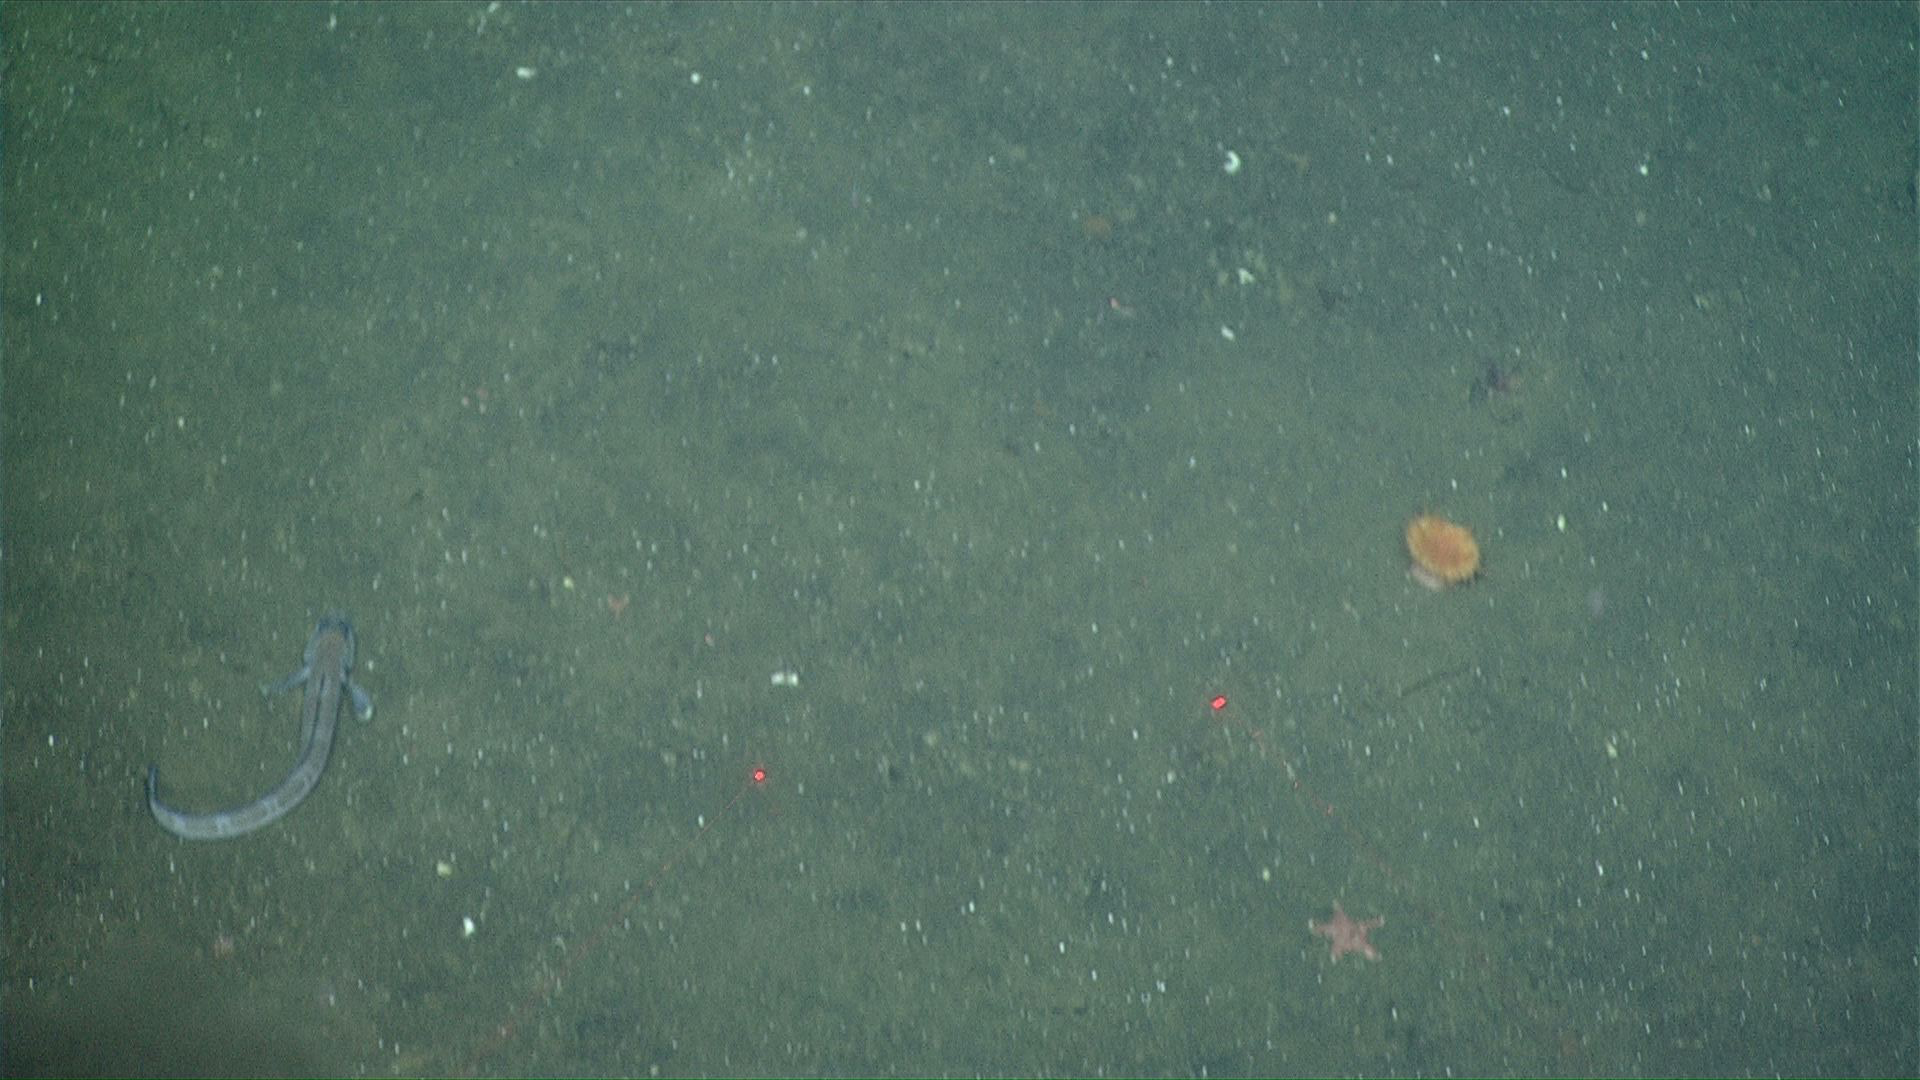

In [115]:
my_row = 57
my_url = train_data.coco_url[my_row]
Image.open(BytesIO(requests.get(my_url).content))

# Evaluation data

In [116]:
with open('../input/fathomnet-out-of-sample-detection/object_detection/eval.json') as f:
    eval_json = json.load(f)
print(eval_json.keys())

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


In [117]:
eval_data = pd.json_normalize(eval_json['images'])
# we can remove "license" as this is always 0
eval_data.drop(['license'], axis=1, inplace=True)
# again add file name based id
eval_data['id_file'] = eval_data.file_name.apply(drop_suffix)
# show preview
eval_data.head(5)

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file
0,1,1920,1079,4172b65a-8b4f-4175-94e4-00187e2d5f33.png,https://fathomnet.org/static/m3/framegrabs/Min...,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05,4172b65a-8b4f-4175-94e4-00187e2d5f33
1,2,713,425,9d263fd4-f786-42bf-8e0c-2d5be7c81b49.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36,9d263fd4-f786-42bf-8e0c-2d5be7c81b49
2,3,720,368,c114ccb9-cf89-4d98-807b-f8636477c6ca.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18,c114ccb9-cf89-4d98-807b-f8636477c6ca
3,4,718,365,95ba3acc-859b-4a99-8c30-b38a91a1be28.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01,95ba3acc-859b-4a99-8c30-b38a91a1be28
4,5,720,368,0c4bdb90-c715-4c01-81d1-aa7f49534ac7.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00,0c4bdb90-c715-4c01-81d1-aa7f49534ac7


In [118]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10744 entries, 0 to 10743
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10744 non-null  int64 
 1   width          10744 non-null  int64 
 2   height         10744 non-null  int64 
 3   file_name      10744 non-null  object
 4   flickr_url     10744 non-null  object
 5   coco_url       10744 non-null  object
 6   date_captured  10744 non-null  object
 7   id_file        10744 non-null  object
dtypes: int64(3), object(5)
memory usage: 671.6+ KB


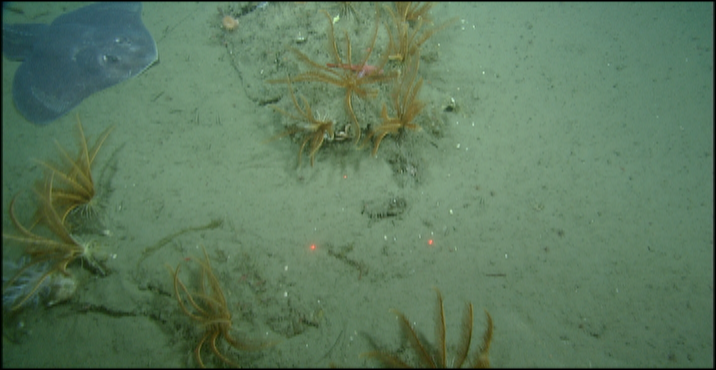

In [119]:
my_row = 10
my_url = eval_data.coco_url[my_row]
Image.open(BytesIO(requests.get(my_url).content))

# Preprocessing

In [120]:
# TODO: load all images and save
train_data.to_csv('train_data.csv', index=False)
eval_data.to_csv('eval_data.csv', index=False)

# Apply model on evaluation set and submit results

In [121]:
eval_data.head()

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file
0,1,1920,1079,4172b65a-8b4f-4175-94e4-00187e2d5f33.png,https://fathomnet.org/static/m3/framegrabs/Min...,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05,4172b65a-8b4f-4175-94e4-00187e2d5f33
1,2,713,425,9d263fd4-f786-42bf-8e0c-2d5be7c81b49.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36,9d263fd4-f786-42bf-8e0c-2d5be7c81b49
2,3,720,368,c114ccb9-cf89-4d98-807b-f8636477c6ca.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18,c114ccb9-cf89-4d98-807b-f8636477c6ca
3,4,718,365,95ba3acc-859b-4a99-8c30-b38a91a1be28.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01,95ba3acc-859b-4a99-8c30-b38a91a1be28
4,5,720,368,0c4bdb90-c715-4c01-81d1-aa7f49534ac7.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00,0c4bdb90-c715-4c01-81d1-aa7f49534ac7


In [122]:
np.random.seed(283947)
def predict_random_categories():
    random_categories = np.random.choice(category_key.id, size=np.random.randint(1, 20), replace=False)
    output = ' '.join(map(str, random_categories))
    return output

eval_data['categories'] = [predict_random_categories() for _ in range(len(eval_data))]
eval_data.head()

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file,categories
0,1,1920,1079,4172b65a-8b4f-4175-94e4-00187e2d5f33.png,https://fathomnet.org/static/m3/framegrabs/Min...,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05,4172b65a-8b4f-4175-94e4-00187e2d5f33,117 56 245 69 168 138 184 220 221 234
1,2,713,425,9d263fd4-f786-42bf-8e0c-2d5be7c81b49.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36,9d263fd4-f786-42bf-8e0c-2d5be7c81b49,102 74 182 52 19 252 203 285 267 205 122 137 2...
2,3,720,368,c114ccb9-cf89-4d98-807b-f8636477c6ca.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18,c114ccb9-cf89-4d98-807b-f8636477c6ca,116
3,4,718,365,95ba3acc-859b-4a99-8c30-b38a91a1be28.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01,95ba3acc-859b-4a99-8c30-b38a91a1be28,163 265 84 160 217 257 81 12 97
4,5,720,368,0c4bdb90-c715-4c01-81d1-aa7f49534ac7.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00,0c4bdb90-c715-4c01-81d1-aa7f49534ac7,92 77 169 289 88 94


In [123]:
np.random.seed(243)
eval_data['osd'] = [np.random.random() for _ in range(len(eval_data))]
eval_data.head()

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file,categories,osd
0,1,1920,1079,4172b65a-8b4f-4175-94e4-00187e2d5f33.png,https://fathomnet.org/static/m3/framegrabs/Min...,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05,4172b65a-8b4f-4175-94e4-00187e2d5f33,117 56 245 69 168 138 184 220 221 234,0.207635
1,2,713,425,9d263fd4-f786-42bf-8e0c-2d5be7c81b49.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36,9d263fd4-f786-42bf-8e0c-2d5be7c81b49,102 74 182 52 19 252 203 285 267 205 122 137 2...,0.781992
2,3,720,368,c114ccb9-cf89-4d98-807b-f8636477c6ca.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18,c114ccb9-cf89-4d98-807b-f8636477c6ca,116,0.606899
3,4,718,365,95ba3acc-859b-4a99-8c30-b38a91a1be28.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01,95ba3acc-859b-4a99-8c30-b38a91a1be28,163 265 84 160 217 257 81 12 97,0.346029
4,5,720,368,0c4bdb90-c715-4c01-81d1-aa7f49534ac7.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00,0c4bdb90-c715-4c01-81d1-aa7f49534ac7,92 77 169 289 88 94,0.404280


In [124]:
# load and show sample submission
sample_submission = pd.read_csv('../input/fathomnet-out-of-sample-detection/sample_submission.csv')
sample_submission.head()

,id,categories,osd
0,8119e2ac-ca3a-4c3b-9e1c-c7a079a705c8,1 146 10 12 44 210,0.1
1,11e2891-93a3-4532-a4ea-6e22e335ae54,17 82 251,0.9


In [125]:
random_preds_submission = {'id': eval_data.id_file, 'categories': eval_data.categories, 'osd': eval_data.osd}
submission = pd.DataFrame(random_preds_submission)
submission.head()

,id,categories,osd
0,4172b65a-8b4f-4175-94e4-00187e2d5f33,117 56 245 69 168 138 184 220 221 234,0.207635
1,9d263fd4-f786-42bf-8e0c-2d5be7c81b49,102 74 182 52 19 252 203 285 267 205 122 137 2...,0.781992
2,c114ccb9-cf89-4d98-807b-f8636477c6ca,116,0.606899
3,95ba3acc-859b-4a99-8c30-b38a91a1be28,163 265 84 160 217 257 81 12 97,0.346029
4,0c4bdb90-c715-4c01-81d1-aa7f49534ac7,92 77 169 289 88 94,0.404280


In [126]:
submission.to_csv('submission.csv', index=False)

In [127]:
assert len(submission) == 10744